In [8]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

In [9]:
# Define paths
data_dir = 'data'
train_dir = os.path.join(data_dir, 'train')
valid_dir = os.path.join(data_dir, 'valid')
test_dir = os.path.join(data_dir, 'test')
model_dir = 'model'
model_path = os.path.join(model_dir, 'vgg19_best_model.keras')
final_model_path = os.path.join(model_dir, 'vgg19_final_model.keras')

In [10]:
# Create model directory if it doesn't exist
os.makedirs(model_dir, exist_ok=True)

In [11]:
# Image data generators for training, validation, and testing sets
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Load VGG19 model without the top layer (include_top=False)
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom top layers
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base VGG19 layers
for layer in base_model.layers:
    layer.trainable = False

Found 2000 images belonging to 3 classes.
Found 149 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


In [12]:
# Kompiler modellen
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Definer ModelCheckpoint for at gemme den bedste model
checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# Træn modellen
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[checkpoint]
)

# Frigør nogle af vgg19 lagene for finjustering
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Kompiler modellen igen med en lavere læringsrate
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Finjuster modellen
history_fine_tune = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[checkpoint]
)

Epoch 1/10


c:\Users\Phillip Risager\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5993 - loss: 14.0782
Epoch 1: val_accuracy improved from -inf to 0.59060, saving model to model\vgg19_best_model.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 116s 2s/step - accuracy: 0.6000 - loss: 13.9582 - val_accuracy: 0.5906 - val_loss: 1.2303
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8665 - loss: 0.3896
Epoch 2: val_accuracy improved from 0.59060 to 0.69799, saving model to model\vgg19_best_model.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.8664 - loss: 0.3895 - val_accuracy: 0.6980 - val_loss: 1.1432
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9378 - loss: 0.1811
Epoch 3: val_accuracy improved from 0.69799 to 0.71141, saving model to model\vgg19_best_model.keras
63/63 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.9380 - loss: 0.1807 - val_accuracy: 0.7114 - val_loss: 1.1217
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9854 - loss: 0.0708
Epoch 4: val_accuracy did not

In [13]:
# Combine history
history.history['accuracy'].extend(history_fine_tune.history['accuracy'])
history.history['val_accuracy'].extend(history_fine_tune.history['val_accuracy'])

# Load the best saved model
best_model = load_model(model_path)

# Save the final model
model.save(final_model_path)

# Define labels
labels = {0: 'Melanoma', 1: 'Nevus', 2: 'Seborrheic Keratosis'}

def load_and_prepare_image(image_path: str, target_size: tuple = (224, 224)) -> np.ndarray:
    """
    Loads and preprocesses an image for VGG19 model prediction.

    Parameters:
    - image_path (str): Path to the image file.
    - target_size (tuple): Desired image size for the model (width, height).

    Returns:
    - np.ndarray: Preprocessed image ready for model input.
    """
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"The image file at {image_path} does not exist.")
    
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=target_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array_expanded = np.expand_dims(img_array, axis=0)
    return preprocess_input(img_array_expanded)

def predict_mole(image_path: str, model: Model) -> str:
    """
    Predicts the class of a mole image using the trained model.

    Parameters:
    - image_path (str): Path to the image file.
    - model (Model): Loaded Keras model.

    Returns:
    - str: Predicted class label with confidence percentage.
    """
    prepared_image = load_and_prepare_image(image_path)
    predictions = model.predict(prepared_image)
    predicted_class_indices = np.argmax(predictions, axis=1)
    confidence = predictions[0][predicted_class_indices[0]] * 100
    predicted_label = labels.get(predicted_class_indices[0], "Unknown")
    return f"The uploaded mole is predicted to be: {predicted_label} with a confidence of {confidence:.2f}%"

# Example usage
test_image_path = 'user_image/test.jpg'

try:
    result = predict_mole(test_image_path, best_model)
    print(result)
except Exception as e:
    print(f"Error: {e}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
The uploaded mole is predicted to be: Nevus with a confidence of 70.40%


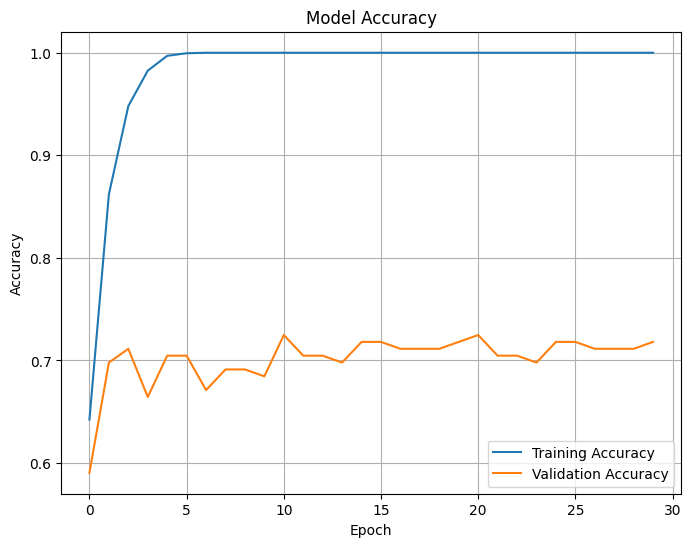

In [14]:
# Plotting accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'] + history_fine_tune.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'] + history_fine_tune.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

Found 600 images belonging to 3 classes.


c:\Users\Phillip Risager\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 65s 3s/step - accuracy: 0.5645 - loss: 2.9247
Test Loss: 1.7369108200073242
Test Accuracy: 0.7099999785423279
19/19 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step
                      precision    recall  f1-score   support

            melanoma       0.53      0.24      0.33       117
               nevus       0.78      0.88      0.82       393
seborrheic_keratosis       0.51      0.60      0.55        90

            accuracy                           0.71       600
           macro avg       0.61      0.57      0.57       600
        weighted avg       0.69      0.71      0.69       600

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


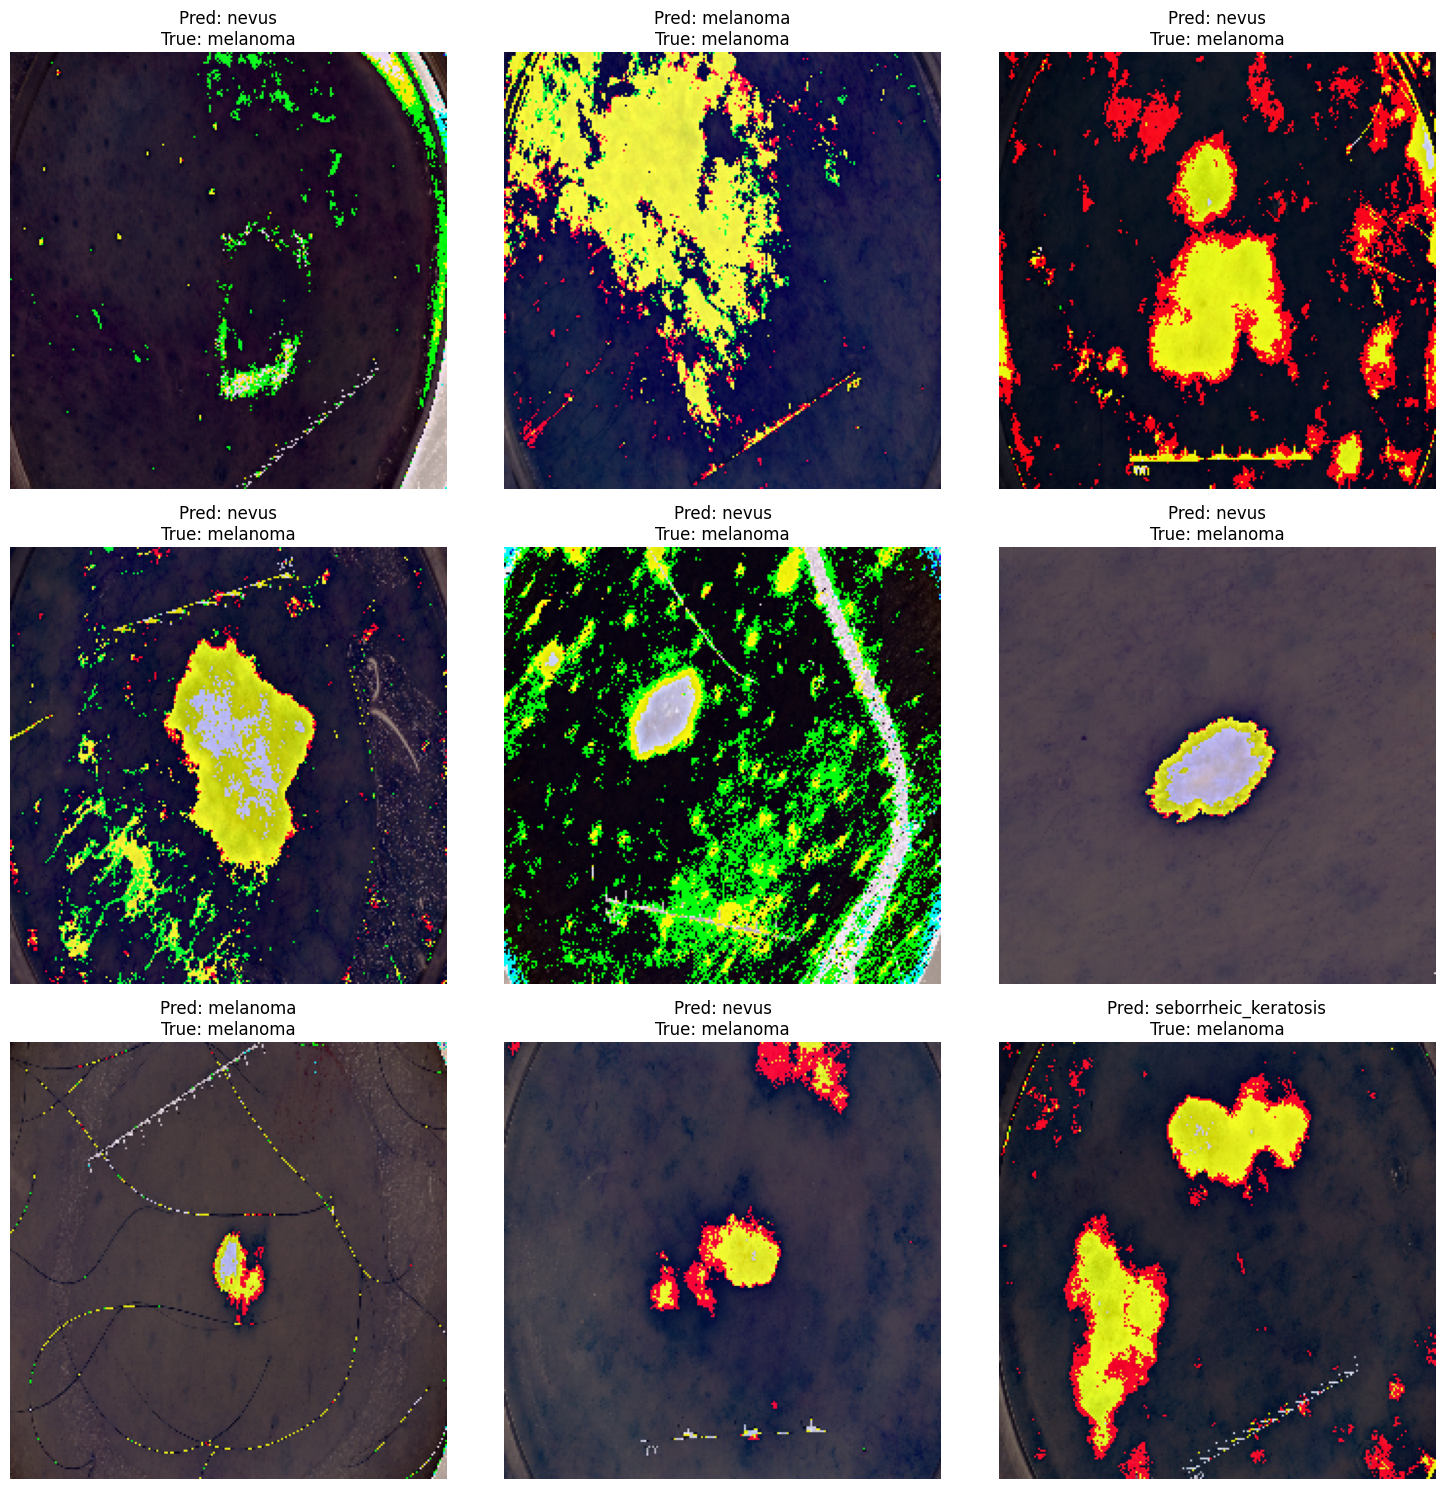

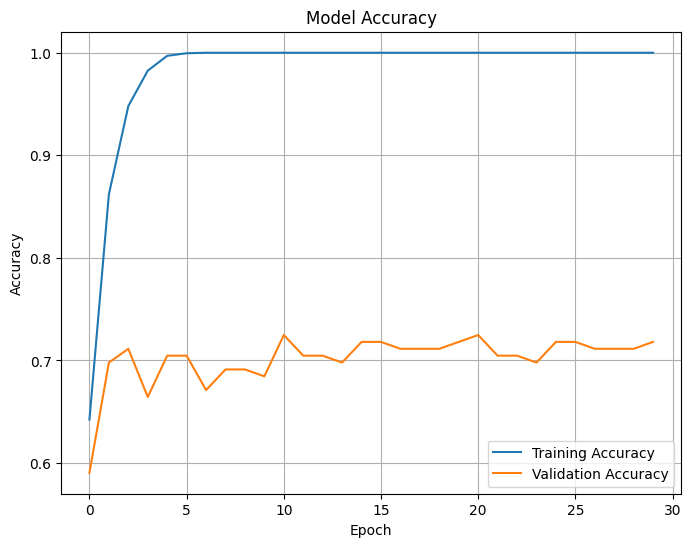

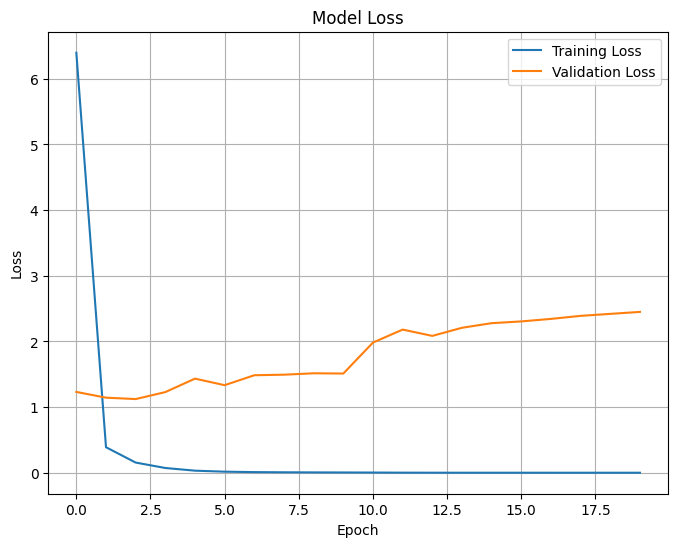

In [15]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Definer stier
data_dir = 'data'
test_dir = os.path.join(data_dir, 'test')
model_dir = 'model'
model_path = os.path.join(model_dir, 'vgg19_best_model.keras')

# Billeddatagenerator for testdata
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Indlæs den bedste model
best_model = load_model(model_path)

# Evaluér modellen på testdatasættet
test_loss, test_accuracy = best_model.evaluate(test_generator)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Forudsig klasser for testdata
predictions = best_model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Hent de faktiske klasser
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Generér en klassifikationsrapport
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

# Visualisering af nogle testbilleder med forudsagte og faktiske etiketter
test_images, test_labels = next(test_generator)

predictions = best_model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()
for img, ax, pred, true in zip(test_images, axes, predicted_classes, test_labels):
    ax.imshow(img.astype('uint8'))
    ax.axis('off')
    ax.set_title(f"Pred: {class_labels[pred]}\nTrue: {class_labels[np.argmax(true)]}")
plt.tight_layout()
plt.show()

# Plot nøjagtighed over epoker
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'] + history_fine_tune.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'] + history_fine_tune.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot tab over epoker
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'] + history_fine_tune.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'] + history_fine_tune.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
